In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

from os.path import join

In [2]:
artifactPath = join("./../server/artifacts/")

In [3]:
df = pd.read_csv("./bengaluru_house_prices.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df = df.drop(labels=['availability', 'area_type', 'society'], axis=1)

In [6]:
df = df.dropna()

In [7]:
df['bhk'] = df['size'].apply(lambda x: int(str(x).split(" ")[0]))

In [8]:
def convertFloat(x):
    a = x.split(" - ")
    if (len(a) == 2):
        return float((float(a[0]) + float(a[1])) / 2)
    try:
        return float(x)
    except:
        return x


def isNumber(x):
    try:
        int(x)
        return True
    except:
        return False

In [9]:
df['total_sqft'] = df['total_sqft'].apply(convertFloat)

In [10]:
df = df[df['total_sqft'].apply(isNumber)]

In [11]:
df.head()

,location,size,total_sqft,bath,balcony,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2


In [12]:
df['total_sqft'] = df['total_sqft'].convert_dtypes('float64')

In [13]:
df2 = df.copy()

In [14]:
df2 = df2.drop(labels='size', axis=1)

In [15]:
df2['Price (price/sqft)'] = df2['price'] * 1_00_000 / df2['total_sqft']

In [16]:
threashold = 10
locationCountAboveThreshold = df2.groupby("location")['location'].count() >= threashold

In [17]:
df2['location'] = df2['location'].apply(lambda x: "Other" if locationCountAboveThreshold[x] == False else x)

{'whiskers': [<matplotlib.lines.Line2D at 0x10cd2da3c10>,
 'caps': [<matplotlib.lines.Line2D at 0x10cd28b3510>,
 'boxes': [<matplotlib.lines.Line2D at 0x10cd2999e10>],
 'medians': [<matplotlib.lines.Line2D at 0x10cd2db3e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x10cd2db10d0>],
 'means': []}

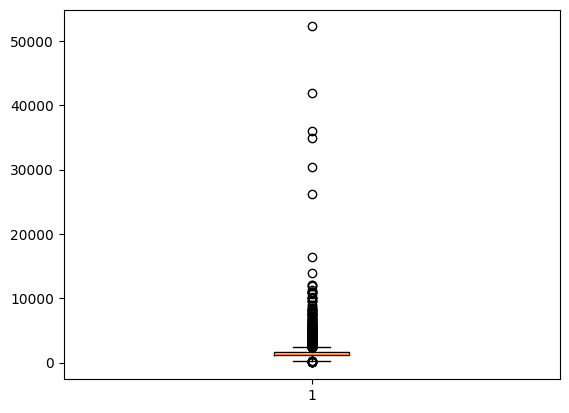

In [18]:
plt.boxplot(df2['total_sqft'])

In [19]:
df2['Price (price/sqft)'].describe()

count         12668.0
mean      6876.277307
std      22633.543076
min        267.829813
25%       4242.720943
50%       5376.344086
75%       7142.857143
max         2300000.0
Name: Price (price/sqft), dtype: Float64

In [20]:
perAbove = np.percentile(df2['Price (price/sqft)'], 90)
perBelow = np.percentile(df2['Price (price/sqft)'], 5)

df3 = df2[(df2['Price (price/sqft)'] < perAbove) & (df2['Price (price/sqft)'] > perBelow)]

In [21]:
df4 = df3[df3['bath'] < df3['bhk'] + 2]

In [22]:
df4.groupby("location")['location'].agg('count').sort_values(ascending=False)

location
Other                   2032
Whitefield               474
Sarjapur  Road           346
Kanakpura Road           253
Thanisandra              224
                        ... 
Thyagaraja Nagar           4
Giri Nagar                 2
HAL 2nd Stage              2
2nd Stage Nagarbhavi       2
Dairy Circle               1
Name: location, Length: 247, dtype: int64

In [23]:
df4['location'] = df4['location'].apply(lambda x: x.strip())

C:\Users\cw\AppData\Local\Temp\ipykernel_16664\3415504596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['location'] = df4['location'].apply(lambda x: x.strip())


In [24]:
excludeIndices = np.array([])
for location, locationDf in df4.groupby('location'):
	bhkStatus = {}
	for bhk, bhkDf in df4.groupby('bhk'):
		bhkStatus[bhk] = {
			'mean': bhkDf['Price (price/sqft)'].mean(),
			'std': bhkDf['Price (price/sqft)'].std(),
			'count': bhkDf['Price (price/sqft)'].count()
		}
	for bhk, bhkDf in locationDf.groupby('bhk'):
		stats = bhkStatus.get(bhk - 1)
		if stats and stats['count'] > 5:
			excludeIndices = np.append(excludeIndices, bhkDf[bhkDf['Price (price/sqft)'] < stats['mean']].index.values)

In [25]:
df5 = df4.drop(excludeIndices, axis='index')

In [26]:
df6 = df5.drop(labels='Price (price/sqft)', axis=1)
labelEncoder = LabelEncoder()
df6['location'] = labelEncoder.fit_transform(df5['location'].apply(lambda x: x.lower()))

In [27]:
df6.head()

,location,total_sqft,bath,balcony,price,bhk
3,155,1521.0,3.0,1.0,95.0,3
11,230,2785.0,5.0,3.0,295.0,4
14,200,2250.0,3.0,2.0,148.0,3
15,168,1175.0,2.0,2.0,73.5,2
18,182,2770.0,4.0,2.0,290.0,3


In [28]:
lr = LinearRegression()

In [29]:
x = df6.drop("price", axis=1)
y = df6['price']
result = cross_val_score(lr, x, y, cv=7)
result.mean()

np.float64(0.8656357966047574)

In [30]:
lr.fit(x, y)

LinearRegression()

In [31]:
r2_score(y, lr.predict(x))

0.8672371253213853

In [32]:
def predectPrice(location, sqft, bath, balcony, bhk):
    return lr.predict([[labelEncoder.transform([location.lower()])[0], sqft, bath, balcony, bhk]])

In [33]:
predectPrice("Thanisandra", 1265, 2, 2, 2)

C:\Users\cw\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([81.91587248])

In [34]:
import pickle
with open(join(artifactPath, 'banglore_home_prices_model.pickle'),'wb') as f:
    pickle.dump(lr,f)
with open(join(artifactPath, 'location.pickle'),'wb') as f:
    pickle.dump(labelEncoder,f)

In [35]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}

with open(join(artifactPath, "columns.json"),"w") as f:
    f.write(json.dumps(columns))